# Visual Curiosity Engine - Multi-Task Model Training

This notebook implements the multi-task architecture as described in the proposal:
- **Heatmap Prediction**: U-Net style decoder for pixel-wise curiosity heatmap
- **Question Generation**: LSTM-based decoder for generating questions

## Architecture Overview

1. **Encoder**: Pre-trained ResNet-34 (lightweight for CPU training)
2. **Heatmap Decoder**: U-Net style with skip connections
3. **Question Decoder**: LSTM-based language model

## Training Strategy

- Multi-task loss combining heatmap MSE and question cross-entropy
- Transfer learning with pre-trained ImageNet weights
- Heavy data augmentation for small dataset
- Gradient accumulation for small batch sizes


In [1]:
import sys
print(sys.executable)


c:\Users\utsag\Downloads\VisualCuriosityEngine\.venv\Scripts\python.exe


In [18]:
# Install required packages if needed
# !pip install torch torchvision tqdm scipy opencv-python

import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add current directory to path
sys.path.append(os.getcwd())

# Import our modules
from data_loader import CuriosityDataset, create_data_loaders
from model import create_model
from trainer import Trainer, Vocabulary

import torch
import torch.nn as nn

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cpu


## Step 1: Prepare Data Loaders


In [19]:
# Configuration
BASE_DIR = '.'  # Current directory containing domain folders
BATCH_SIZE = 2  # Small batch size for CPU/memory constraints
IMAGE_SIZE = 1024
NUM_WORKERS = 0  # 0 for Windows compatibility

# Data split configuration
TRAIN_IMAGES_PER_DOMAIN = 28  # 28 images randomly selected from each domain for training
VAL_IMAGES_PER_DOMAIN = 6     # 6 images from each domain for validation

train_loader, val_loader = create_data_loaders(
    base_dir=BASE_DIR,
    train_images_per_domain=TRAIN_IMAGES_PER_DOMAIN,
    val_images_per_domain=VAL_IMAGES_PER_DOMAIN,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    num_workers=NUM_WORKERS,
    random_seed=42  # For reproducibility
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test data loading
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Images: {sample_batch['image'].shape}")
print(f"  Heatmaps: {sample_batch['heatmap'].shape}")
print(f"  Questions: {sample_batch['question'][:2]}")


Domain Domain_1_Images: 28 train, 6 validation (total available: 40)
Domain Domain_2_Images: 28 train, 6 validation (total available: 40)
Domain Domain_3_Images: 28 train, 6 validation (total available: 40)
Domain Domain_4_Images: 28 train, 6 validation (total available: 40)
Domain Domain_5_Images: 28 train, 6 validation (total available: 40)

Total: 140 training samples, 30 validation samples
Loaded 140 pre-selected samples
Loaded 30 pre-selected samples

Train batches: 70
Validation batches: 30

Sample batch:
  Images: torch.Size([2, 3, 1024, 1024])
  Heatmaps: torch.Size([2, 1024, 1024])
  Questions: ['what is inside the pot?', 'why is the cat there?']


## Step 2: Build Vocabulary


In [20]:
# # Build vocabulary from training data
# vocab = Vocabulary()

# print("Building vocabulary from training data...")
# for batch in train_loader:
#     for question in batch['question']:
#         vocab.add_sentence(question)

# print(f"Vocabulary size: {len(vocab)}")
# print(f"Sample words: {list(vocab.word2idx.keys())[:20]}")

# # Test tokenization
# test_question = "why is the man sitting like that?"
# tokens = vocab.sentence_to_indices(test_question)
# print(f"\nTest question: '{test_question}'")
# print(f"Tokens: {tokens}")
# print(f"Reconstructed: '{vocab.indices_to_sentence(tokens)}'")

# Build vocabulary from training data - FIXED VERSION
# This version directly accesses the dataset samples to avoid negative stride errors
# by skipping image/heatmap loading entirely

vocab = Vocabulary()

print("Building vocabulary from training data...")

# Access the underlying dataset samples directly (no image loading needed)
train_dataset = train_loader.dataset

# Get questions directly from samples without loading images/heatmaps
for sample in train_dataset.samples:
    # Use the dataset's get_primary_question method
    question = train_dataset.get_primary_question(
        sample.get('questions', []),
        sample.get('question_types', [])
    )
    vocab.add_sentence(question)

print(f"Vocabulary size: {len(vocab)}")
print(f"Sample words: {list(vocab.word2idx.keys())[:20]}")

# Test tokenization
test_question = "why is the man sitting like that?"
tokens = vocab.sentence_to_indices(test_question)
print(f"\nTest question: '{test_question}'")
print(f"Tokens: {tokens}")
print(f"Reconstructed: '{vocab.indices_to_sentence(tokens)}'")



Building vocabulary from training data...
Vocabulary size: 157
Sample words: ['<PAD>', '<UNK>', '<START>', '<END>', 'why', 'is', 'the', 'man', 'using', 'a', 'binocular?', 'person', 'writing', 'in', 'notepad?', 'balloon', 'looking', 'like', 'sofa?', 'laptop']

Test question: 'why is the man sitting like that?'
Tokens: [2, 4, 5, 6, 7, 24, 17, 23, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reconstructed: 'why is the man sitting like that?'


## Step 3: Create Model


In [21]:
# Create model
model = create_model(
    backbone='resnet34',  # Use resnet34 for CPU efficiency (can use resnet18 for even faster)
    vocab_size=len(vocab),
    use_question_head=True
)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optionally freeze encoder initially (transfer learning)
# model.freeze_encoder(freeze=True)
# print("Encoder frozen for initial training")


Total parameters: 24,262,046
Trainable parameters: 24,262,046


## Step 4: Setup Trainer


In [22]:
# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    device=device,
    learning_rate=1e-4,
    heatmap_weight=1.0,  # Weight for heatmap loss
    question_weight=1.0,  # Weight for question loss
    save_dir='checkpoints'
)

print("Trainer created successfully!")


Trainer created successfully!


## Step 5: Train Model


In [7]:
# Train the model
NUM_EPOCHS = 50  # Adjust based on your needs
SAVE_EVERY = 5  # Save checkpoint every N epochs

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"This may take a while on CPU...")

history = trainer.train(num_epochs=NUM_EPOCHS, save_every=SAVE_EVERY)

print("\nTraining completed!")


Starting training for 50 epochs...
This may take a while on CPU...


Validating: 100%|██████████| 30/30 [00:37<00:00,  1.26s/it]



Epoch 1/50
Train Loss: 4.2253 | Val Loss: 3.3550
Train HM Loss: 0.0375 | Train Q Loss: 4.1878
Val HM Loss: 0.0179 | Val Q Loss: 3.3371
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:41<00:00,  1.38s/it]



Epoch 2/50
Train Loss: 2.6326 | Val Loss: 2.4842
Train HM Loss: 0.0155 | Train Q Loss: 2.6170
Val HM Loss: 0.0131 | Val Q Loss: 2.4711
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]



Epoch 3/50
Train Loss: 2.1356 | Val Loss: 2.3185
Train HM Loss: 0.0130 | Train Q Loss: 2.1226
Val HM Loss: 0.0125 | Val Q Loss: 2.3060
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:41<00:00,  1.40s/it]



Epoch 4/50
Train Loss: 1.9853 | Val Loss: 2.2482
Train HM Loss: 0.0115 | Train Q Loss: 1.9737
Val HM Loss: 0.0118 | Val Q Loss: 2.2364
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]



Epoch 5/50
Train Loss: 1.8812 | Val Loss: 2.1923
Train HM Loss: 0.0094 | Train Q Loss: 1.8718
Val HM Loss: 0.0109 | Val Q Loss: 2.1814
Saved checkpoint to checkpoints\best_model.pth
Saved checkpoint to checkpoints\checkpoint_epoch_5.pth


Validating: 100%|██████████| 30/30 [00:38<00:00,  1.30s/it]



Epoch 6/50
Train Loss: 1.8021 | Val Loss: 2.1496
Train HM Loss: 0.0087 | Train Q Loss: 1.7934
Val HM Loss: 0.0109 | Val Q Loss: 2.1386
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]



Epoch 7/50
Train Loss: 1.7252 | Val Loss: 2.1118
Train HM Loss: 0.0077 | Train Q Loss: 1.7174
Val HM Loss: 0.0102 | Val Q Loss: 2.1017
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]



Epoch 8/50
Train Loss: 1.6475 | Val Loss: 2.0810
Train HM Loss: 0.0081 | Train Q Loss: 1.6394
Val HM Loss: 0.0113 | Val Q Loss: 2.0697
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]



Epoch 9/50
Train Loss: 1.5994 | Val Loss: 2.0597
Train HM Loss: 0.0080 | Train Q Loss: 1.5914
Val HM Loss: 0.0102 | Val Q Loss: 2.0495
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]



Epoch 10/50
Train Loss: 1.5379 | Val Loss: 2.0357
Train HM Loss: 0.0078 | Train Q Loss: 1.5301
Val HM Loss: 0.0127 | Val Q Loss: 2.0230
Saved checkpoint to checkpoints\best_model.pth
Saved checkpoint to checkpoints\checkpoint_epoch_10.pth


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]



Epoch 11/50
Train Loss: 1.4784 | Val Loss: 2.0430
Train HM Loss: 0.0079 | Train Q Loss: 1.4705
Val HM Loss: 0.0137 | Val Q Loss: 2.0292


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]



Epoch 12/50
Train Loss: 1.4483 | Val Loss: 2.0247
Train HM Loss: 0.0091 | Train Q Loss: 1.4392
Val HM Loss: 0.0111 | Val Q Loss: 2.0136
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.30s/it]



Epoch 13/50
Train Loss: 1.4088 | Val Loss: 2.0139
Train HM Loss: 0.0092 | Train Q Loss: 1.3996
Val HM Loss: 0.0112 | Val Q Loss: 2.0027
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]



Epoch 14/50
Train Loss: 1.3668 | Val Loss: 2.0061
Train HM Loss: 0.0083 | Train Q Loss: 1.3586
Val HM Loss: 0.0124 | Val Q Loss: 1.9937
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it]



Epoch 15/50
Train Loss: 1.3378 | Val Loss: 2.0121
Train HM Loss: 0.0098 | Train Q Loss: 1.3280
Val HM Loss: 0.0149 | Val Q Loss: 1.9972
Saved checkpoint to checkpoints\checkpoint_epoch_15.pth


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]



Epoch 16/50
Train Loss: 1.2923 | Val Loss: 1.9930
Train HM Loss: 0.0095 | Train Q Loss: 1.2827
Val HM Loss: 0.0118 | Val Q Loss: 1.9812
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:50<00:00,  1.68s/it]



Epoch 17/50
Train Loss: 1.2617 | Val Loss: 1.9961
Train HM Loss: 0.0095 | Train Q Loss: 1.2522
Val HM Loss: 0.0117 | Val Q Loss: 1.9844


Validating: 100%|██████████| 30/30 [00:38<00:00,  1.30s/it]



Epoch 18/50
Train Loss: 1.2376 | Val Loss: 1.9987
Train HM Loss: 0.0093 | Train Q Loss: 1.2283
Val HM Loss: 0.0132 | Val Q Loss: 1.9855


Validating: 100%|██████████| 30/30 [00:38<00:00,  1.29s/it]



Epoch 19/50
Train Loss: 1.2106 | Val Loss: 2.0085
Train HM Loss: 0.0101 | Train Q Loss: 1.2005
Val HM Loss: 0.0145 | Val Q Loss: 1.9940


Validating: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]



Epoch 20/50
Train Loss: 1.1703 | Val Loss: 1.9995
Train HM Loss: 0.0105 | Train Q Loss: 1.1598
Val HM Loss: 0.0122 | Val Q Loss: 1.9872
Saved checkpoint to checkpoints\checkpoint_epoch_20.pth


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.33s/it]



Epoch 21/50
Train Loss: 1.1609 | Val Loss: 1.9926
Train HM Loss: 0.0098 | Train Q Loss: 1.1511
Val HM Loss: 0.0105 | Val Q Loss: 1.9821
Saved checkpoint to checkpoints\best_model.pth


Validating: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]



Epoch 22/50
Train Loss: 1.1250 | Val Loss: 1.9973
Train HM Loss: 0.0090 | Train Q Loss: 1.1160
Val HM Loss: 0.0114 | Val Q Loss: 1.9859


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]



Epoch 23/50
Train Loss: 1.1006 | Val Loss: 2.0086
Train HM Loss: 0.0090 | Train Q Loss: 1.0915
Val HM Loss: 0.0110 | Val Q Loss: 1.9976


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.30s/it]



Epoch 24/50
Train Loss: 1.0779 | Val Loss: 2.0073
Train HM Loss: 0.0094 | Train Q Loss: 1.0686
Val HM Loss: 0.0103 | Val Q Loss: 1.9971


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]



Epoch 25/50
Train Loss: 1.0582 | Val Loss: 2.0194
Train HM Loss: 0.0088 | Train Q Loss: 1.0494
Val HM Loss: 0.0108 | Val Q Loss: 2.0086
Saved checkpoint to checkpoints\checkpoint_epoch_25.pth


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it]



Epoch 26/50
Train Loss: 1.0318 | Val Loss: 2.0353
Train HM Loss: 0.0087 | Train Q Loss: 1.0231
Val HM Loss: 0.0109 | Val Q Loss: 2.0244


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 27/50
Train Loss: 1.0083 | Val Loss: 2.0191
Train HM Loss: 0.0089 | Train Q Loss: 0.9993
Val HM Loss: 0.0122 | Val Q Loss: 2.0069


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.33s/it]



Epoch 28/50
Train Loss: 0.9878 | Val Loss: 2.0257
Train HM Loss: 0.0088 | Train Q Loss: 0.9790
Val HM Loss: 0.0103 | Val Q Loss: 2.0154


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 29/50
Train Loss: 0.9672 | Val Loss: 2.0563
Train HM Loss: 0.0086 | Train Q Loss: 0.9586
Val HM Loss: 0.0103 | Val Q Loss: 2.0460


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]



Epoch 30/50
Train Loss: 0.9592 | Val Loss: 2.0679
Train HM Loss: 0.0082 | Train Q Loss: 0.9510
Val HM Loss: 0.0105 | Val Q Loss: 2.0574
Saved checkpoint to checkpoints\checkpoint_epoch_30.pth


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]



Epoch 31/50
Train Loss: 0.9468 | Val Loss: 2.0762
Train HM Loss: 0.0076 | Train Q Loss: 0.9392
Val HM Loss: 0.0103 | Val Q Loss: 2.0659


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 32/50
Train Loss: 0.9362 | Val Loss: 2.0645
Train HM Loss: 0.0072 | Train Q Loss: 0.9290
Val HM Loss: 0.0102 | Val Q Loss: 2.0543


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]



Epoch 33/50
Train Loss: 0.9161 | Val Loss: 2.0976
Train HM Loss: 0.0075 | Train Q Loss: 0.9087
Val HM Loss: 0.0106 | Val Q Loss: 2.0870


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 34/50
Train Loss: 0.9057 | Val Loss: 2.0843
Train HM Loss: 0.0068 | Train Q Loss: 0.8989
Val HM Loss: 0.0105 | Val Q Loss: 2.0738


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 35/50
Train Loss: 0.9036 | Val Loss: 2.1041
Train HM Loss: 0.0067 | Train Q Loss: 0.8969
Val HM Loss: 0.0099 | Val Q Loss: 2.0942
Saved checkpoint to checkpoints\checkpoint_epoch_35.pth


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 36/50
Train Loss: 0.8963 | Val Loss: 2.0979
Train HM Loss: 0.0065 | Train Q Loss: 0.8898
Val HM Loss: 0.0100 | Val Q Loss: 2.0879


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]



Epoch 37/50
Train Loss: 0.9114 | Val Loss: 2.1064
Train HM Loss: 0.0064 | Train Q Loss: 0.9050
Val HM Loss: 0.0101 | Val Q Loss: 2.0963


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]



Epoch 38/50
Train Loss: 0.8849 | Val Loss: 2.0899
Train HM Loss: 0.0060 | Train Q Loss: 0.8789
Val HM Loss: 0.0105 | Val Q Loss: 2.0795


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 39/50
Train Loss: 0.9003 | Val Loss: 2.0717
Train HM Loss: 0.0061 | Train Q Loss: 0.8943
Val HM Loss: 0.0106 | Val Q Loss: 2.0611


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.33s/it]



Epoch 40/50
Train Loss: 0.8825 | Val Loss: 2.0739
Train HM Loss: 0.0057 | Train Q Loss: 0.8767
Val HM Loss: 0.0101 | Val Q Loss: 2.0638
Saved checkpoint to checkpoints\checkpoint_epoch_40.pth


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 41/50
Train Loss: 0.8810 | Val Loss: 2.0950
Train HM Loss: 0.0058 | Train Q Loss: 0.8752
Val HM Loss: 0.0100 | Val Q Loss: 2.0850


Validating: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]



Epoch 42/50
Train Loss: 0.8726 | Val Loss: 2.0837
Train HM Loss: 0.0055 | Train Q Loss: 0.8671
Val HM Loss: 0.0100 | Val Q Loss: 2.0738


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]



Epoch 43/50
Train Loss: 0.8677 | Val Loss: 2.0956
Train HM Loss: 0.0056 | Train Q Loss: 0.8621
Val HM Loss: 0.0102 | Val Q Loss: 2.0854


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it]



Epoch 44/50
Train Loss: 0.8661 | Val Loss: 2.0803
Train HM Loss: 0.0052 | Train Q Loss: 0.8609
Val HM Loss: 0.0103 | Val Q Loss: 2.0700


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.33s/it]



Epoch 45/50
Train Loss: 0.8706 | Val Loss: 2.1038
Train HM Loss: 0.0051 | Train Q Loss: 0.8655
Val HM Loss: 0.0103 | Val Q Loss: 2.0935
Saved checkpoint to checkpoints\checkpoint_epoch_45.pth


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]



Epoch 46/50
Train Loss: 0.8567 | Val Loss: 2.1095
Train HM Loss: 0.0050 | Train Q Loss: 0.8517
Val HM Loss: 0.0100 | Val Q Loss: 2.0995


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.33s/it]



Epoch 47/50
Train Loss: 0.8569 | Val Loss: 2.0961
Train HM Loss: 0.0050 | Train Q Loss: 0.8519
Val HM Loss: 0.0100 | Val Q Loss: 2.0861


Validating: 100%|██████████| 30/30 [00:41<00:00,  1.37s/it]



Epoch 48/50
Train Loss: 0.8583 | Val Loss: 2.0965
Train HM Loss: 0.0050 | Train Q Loss: 0.8533
Val HM Loss: 0.0105 | Val Q Loss: 2.0860


Validating: 100%|██████████| 30/30 [00:39<00:00,  1.33s/it]



Epoch 49/50
Train Loss: 0.8716 | Val Loss: 2.0892
Train HM Loss: 0.0050 | Train Q Loss: 0.8666
Val HM Loss: 0.0103 | Val Q Loss: 2.0790


Validating: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]



Epoch 50/50
Train Loss: 0.8566 | Val Loss: 2.1103
Train HM Loss: 0.0050 | Train Q Loss: 0.8517
Val HM Loss: 0.0101 | Val Q Loss: 2.1002
Saved checkpoint to checkpoints\checkpoint_epoch_50.pth

Training completed!


## Step 6: Visualize Training Results


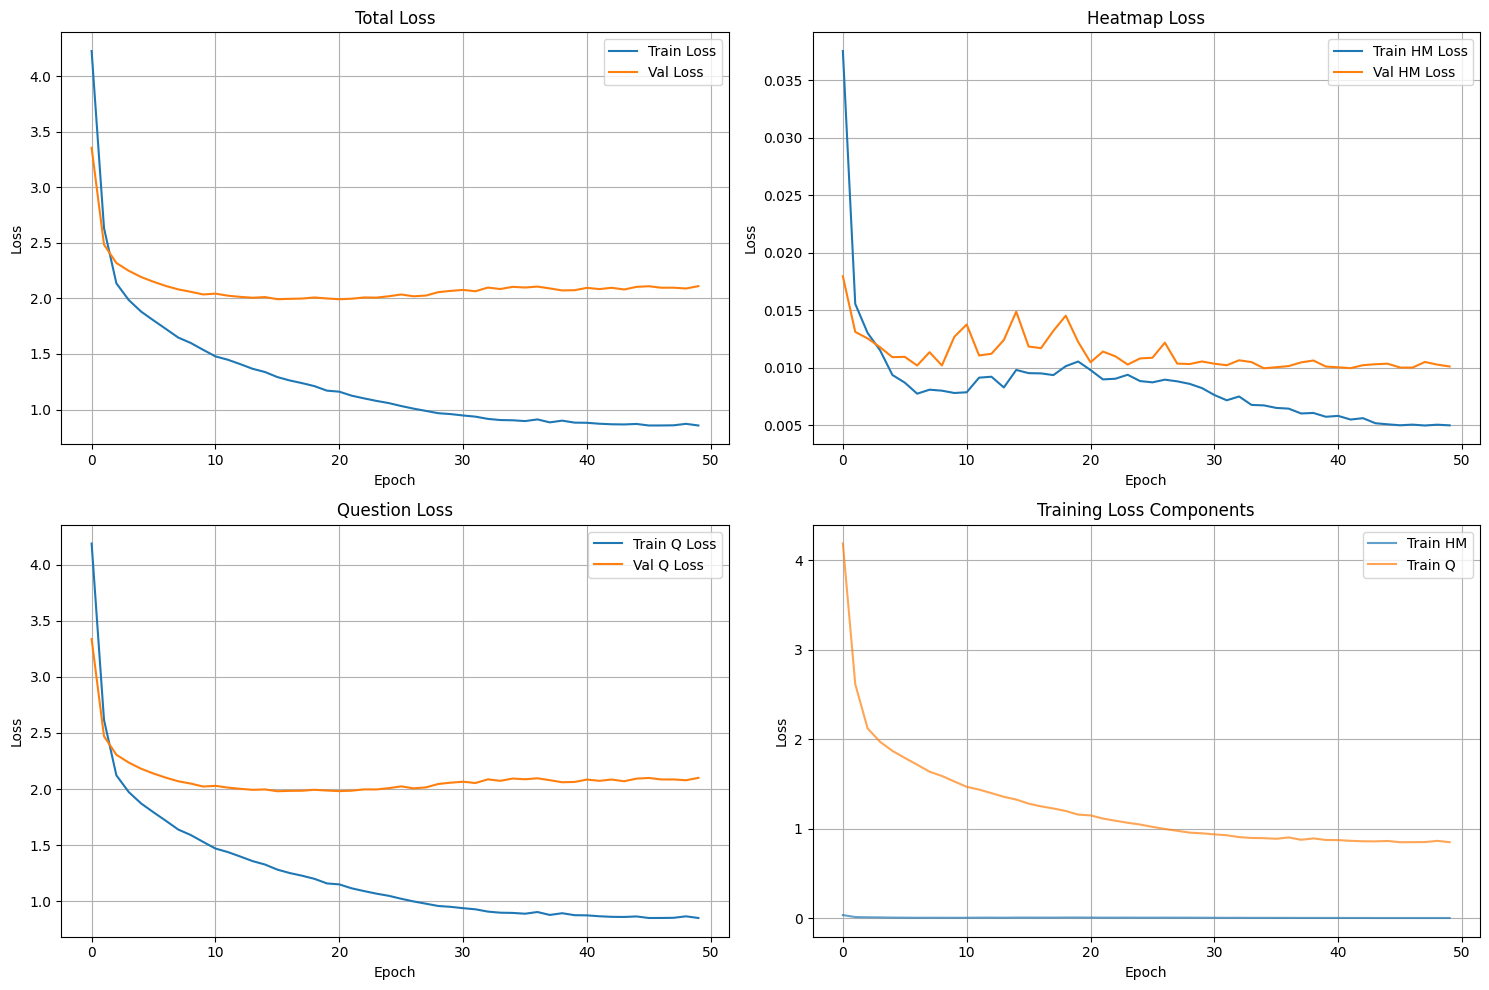

In [8]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total loss
axes[0, 0].plot(history['train_loss'], label='Train Loss')
axes[0, 0].plot(history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Heatmap loss
axes[0, 1].plot(history['train_heatmap_loss'], label='Train HM Loss')
axes[0, 1].plot(history['val_heatmap_loss'], label='Val HM Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Heatmap Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Question loss
axes[1, 0].plot(history['train_question_loss'], label='Train Q Loss')
axes[1, 0].plot(history['val_question_loss'], label='Val Q Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Question Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Combined view
axes[1, 1].plot(history['train_heatmap_loss'], label='Train HM', alpha=0.7)
axes[1, 1].plot(history['train_question_loss'], label='Train Q', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training Loss Components')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()


## Step 7: Test Inference


Using device: cpu
Loaded checkpoint from checkpoints/best_model.pth


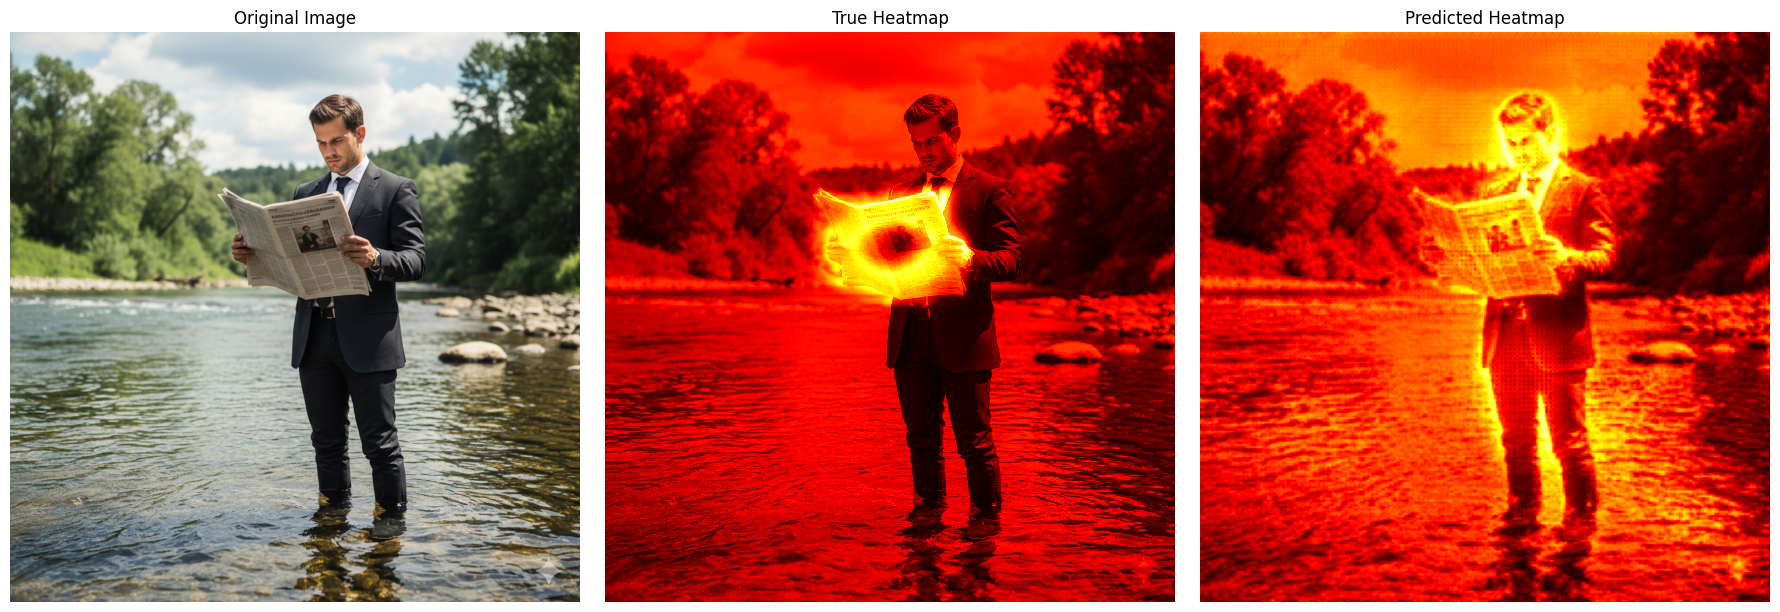


True Question: why is the person reading newspaper there?
Predicted Question: why is the cat there?


In [11]:
# Install required packages if needed
# !pip install torch torchvision tqdm scipy opencv-python

import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add current directory to path
sys.path.append(os.getcwd())

# Import our modules
from data_loader import CuriosityDataset, create_data_loaders
from model import create_model
from trainer import Trainer, Vocabulary

import torch
import torch.nn as nn

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.serialization.add_safe_globals([Vocabulary])
# Load best model
trainer.load_checkpoint('checkpoints/best_model.pth')

# Test on a validation sample
model.eval()
with torch.no_grad():
    sample_batch = next(iter(val_loader))
    images = sample_batch['image'].to(device)
    true_heatmaps = sample_batch['heatmap'].to(device)
    true_questions = sample_batch['question']
    
    # Get predictions
    predictions = model(images, return_heatmap=True, return_question=True)
    
    pred_heatmaps = predictions['heatmap'].cpu()
    pred_question_logits = predictions['question'].cpu()
    
    # Decode question
    pred_tokens = pred_question_logits.argmax(dim=-1)[0]
    pred_question = vocab.indices_to_sentence(pred_tokens.tolist())

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
img = images[0].cpu()
img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img = torch.clamp(img, 0, 1)
axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')

# True heatmap
axes[1].imshow(true_heatmaps[0].cpu().numpy(), cmap='hot', interpolation='nearest')
axes[1].set_title('True Heatmap')
axes[1].axis('off')

# Predicted heatmap
axes[2].imshow(pred_heatmaps[0, 0].cpu().numpy(), cmap='hot', interpolation='nearest')
axes[2].set_title('Predicted Heatmap')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('inference_sample.png', dpi=150)
plt.show()

print(f"\nTrue Question: {true_questions[0]}")
print(f"Predicted Question: {pred_question}")


In [ ]:
# Load best model
trainer.load_checkpoint('checkpoints/best_model.pth')

# Set model to evaluation mode
model.eval()

# Directory to save results
os.makedirs('inference_results', exist_ok=True)

# Number of samples to visualize
num_samples_to_show = 30

with torch.no_grad():
    # Loop through multiple samples from the validation (or test) loader
    for idx, sample_batch in enumerate(val_loader):
        if idx >= num_samples_to_show:
            break

        images = sample_batch['image'].to(device)
        true_heatmaps = sample_batch['heatmap'].to(device)
        true_questions = sample_batch['question']

        # Model predictions
        predictions = model(images, return_heatmap=True, return_question=True)
        pred_heatmaps = predictions['heatmap'].cpu()
        pred_question_logits = predictions['question'].cpu()

        # Iterate over each image in the batch
        for i in range(images.size(0)):
            # Decode predicted question
            pred_tokens = pred_question_logits.argmax(dim=-1)[i]
            pred_question = vocab.indices_to_sentence(pred_tokens.tolist())

            # Visualization setup
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Original image (unnormalize)
            img = images[i].cpu()
            img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img = torch.clamp(img, 0, 1)
            axes[0].imshow(img.permute(1, 2, 0))
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            # True heatmap
            axes[1].imshow(true_heatmaps[i].cpu().numpy(), cmap='hot', interpolation='nearest')
            axes[1].set_title('True Heatmap')
            axes[1].axis('off')

            # Predicted heatmap
            axes[2].imshow(pred_heatmaps[i, 0].cpu().numpy(), cmap='hot', interpolation='nearest')
            axes[2].set_title('Predicted Heatmap')
            axes[2].axis('off')

            plt.tight_layout()

            # Save output to file
            save_path = f"inference_results/sample_{idx}_{i}.png"
            plt.savefig(save_path, dpi=150)
            plt.close(fig)

            # Print text results
            print(f"\n Saved inference result: {save_path}")
            print(f"True Question: {true_questions[i]}")
            print(f"Predicted Question: {pred_question}")

print("\n Inference complete. All visualizations saved in 'inference_results/' folder.")


Loaded checkpoint from checkpoints/best_model.pth

 Saved inference result: inference_results/sample_0_0.png
True Question: why is the person reading newspaper there?
Predicted Question: why is the cat there?

 Saved inference result: inference_results/sample_1_0.png
True Question: what is there inside the cup?
Predicted Question: why is the cat there?

 Saved inference result: inference_results/sample_2_0.png
True Question: why is the table there?
Predicted Question: why is the cat there?

 Saved inference result: inference_results/sample_3_0.png
True Question: why is there a pile of stones?
Predicted Question: why is the cat there?

 Saved inference result: inference_results/sample_4_0.png
True Question: why is the board transparent?
Predicted Question: why is the cat there?

 Saved inference result: inference_results/sample_5_0.png
True Question: what is the man doing with the pen?
Predicted Question: why is the cat there?

 Saved inference result: inference_results/sample_6_0.png
T

In [33]:
import cv2
import numpy as np
from scipy.stats import pearsonr, spearmanr
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import torch

def dcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    return np.sum((2**relevances - 1) / np.log2(np.arange(2, k+2)))

def ndcg_at_k(gt, pred, k=5):
    pred_sorted = np.argsort(pred)[::-1]
    gt_sorted   = np.argsort(gt)[::-1]

    rel_pred  = gt[pred_sorted][:k]
    rel_ideal = gt[gt_sorted][:k]

    dcg  = dcg_at_k(rel_pred, k)
    idcg = dcg_at_k(rel_ideal, k)

    return (dcg / idcg) if idcg > 0 else 0.0

metrics_list = {
    "Pearson": [],
    "SSIM": [],
    "MSE": [],
    "Spearman": [],
    "NDCG@5": []
}

def compute_metrics(gt_map, pred_map):

    # Flatten
    gt_flat   = gt_map.flatten()
    pred_flat = pred_map.flatten()

    # Handle constant maps
    if np.std(gt_flat) == 0 or np.std(pred_flat) == 0:
        pear = 0
        spear = 0
        ssim_val = 0
    else:
        pear, _  = pearsonr(gt_flat, pred_flat)
        spear, _ = spearmanr(gt_flat, pred_flat)

        data_range = max(pred_map.max() - pred_map.min(), 1e-6)
        ssim_val = ssim(gt_map, pred_map, data_range=data_range)

    mse_val  = np.mean((gt_flat - pred_flat)**2)
    ndcg_val = ndcg_at_k(gt_flat, pred_flat, k=5)

    return pear, ssim_val, mse_val, spear, ndcg_val

print("\n Computing curiosity heatmap metrics...\n")

with torch.no_grad():
    for idx, batch in enumerate(val_loader):

        images = batch['image'].to(device)
        true_heatmaps = batch['heatmap'].to(device)

        # Model returns a dict
        preds = model(images, return_heatmap=True, return_question=True)
        pred_heatmaps = preds["heatmap"].cpu()

        for i in range(images.size(0)):

            # Ground truth
            gt = true_heatmaps[i].cpu().numpy()   # shape = (H_gt, W_gt)

            # Prediction (B,1,H_pred,W_pred) → (H_pred,W_pred)
            pred_raw = pred_heatmaps[i, 0].cpu().numpy()

            # Resize prediction to GT size
            pred = cv2.resize(pred_raw, (gt.shape[1], gt.shape[0]), interpolation=cv2.INTER_LINEAR)

            # Compute metrics
            pear, ssim_val, mse_val, spear, ndcg_val = compute_metrics(gt, pred)

            # Store
            metrics_list["Pearson"].append(pear)
            metrics_list["SSIM"].append(ssim_val)
            metrics_list["MSE"].append(mse_val)
            metrics_list["Spearman"].append(spear)
            metrics_list["NDCG@5"].append(ndcg_val)

summary = {m: float(np.mean(v)) for m, v in metrics_list.items()}
df = pd.DataFrame.from_dict(summary, orient='index', columns=["Score"])
df.index.name = "Metric"

print("\n Final Evaluation Metrics Across Validation Set \n")
print(df.to_markdown(tablefmt="github", floatfmt=".7f"))



 Computing curiosity heatmap metrics...


 Final Evaluation Metrics Across Validation Set 

| Metric   |     Score |
|----------|-----------|
| Pearson  | 0.7569647 |
| SSIM     | 0.8123110 |
| MSE      | 0.0104646 |
| Spearman | 0.8331773 |
| NDCG@5   | 0.2798121 |


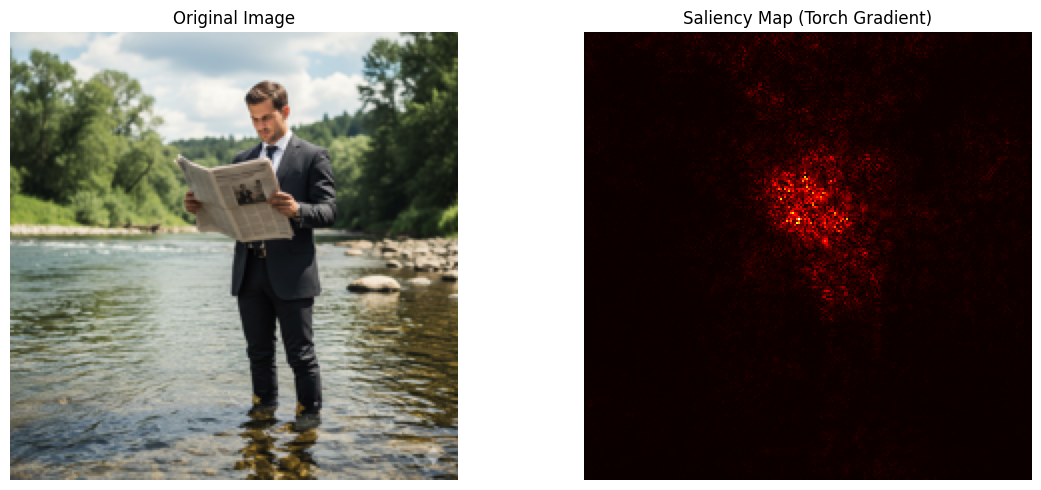

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = models.resnet50(pretrained=True)
model.eval()

image_path = "Domain_1_Images/img_004.png" 
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

input_tensor = transform(image).unsqueeze(0)  # shape: [1, 3, 224, 224]
input_tensor.requires_grad = True  # 🔹 Needed for saliency computation


output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

model.zero_grad()
output[0, pred_class].backward()

saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)
saliency = saliency.squeeze().cpu().numpy()

# Convert original image for plotting
orig_img = np.array(image.resize((224, 224)))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Saliency Map (Torch Gradient)")
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.tight_layout()
plt.show()
